In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Harsh Naik
- PRN : 8013

# Deep Neural Networks 
## Assignment 02


## Implementation of Perceptron

###  Take this notebook and modify the code to implement sigmoid activation function


## 1. Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
%matplotlib inline

## 2. Setup Global Parameters

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 200  # number of epochs
ALPHA = 0.1  # learning rate

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.1em;color:black;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [4]:
X, y = datasets.make_moons(n_samples=1000, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;color:black;">
DataFrames are easier to visualize
</p>

In [5]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe() # Generate descriptive statistic

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [8]:
# what labels are present?
data_df.target.unique()

array([0, 1], dtype=int64)

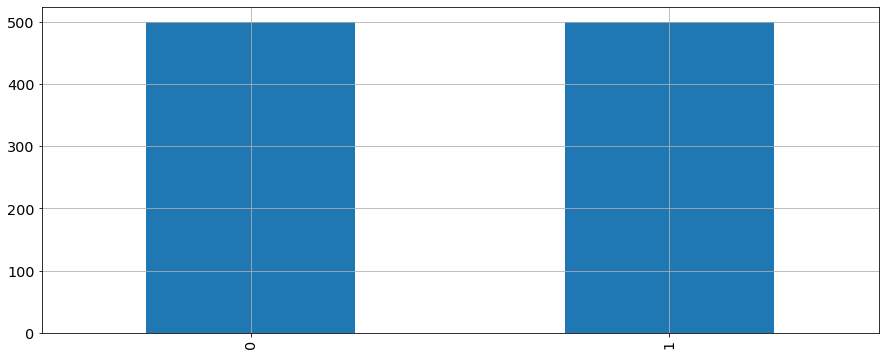

In [9]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

ax.grid();

### 4.1 Different ways of plotting data

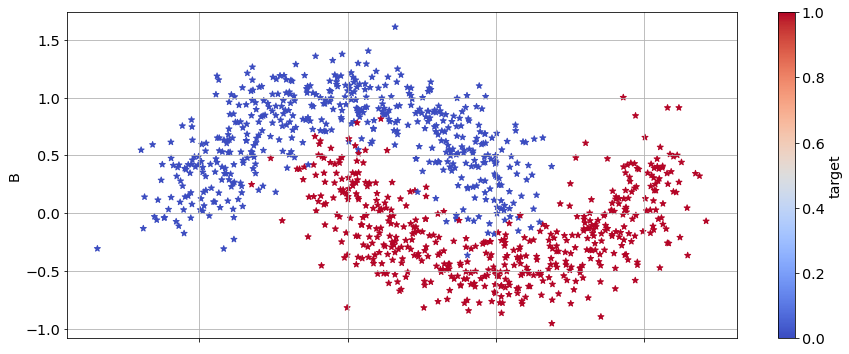

In [10]:
# Plot the data
data_df.plot.scatter('A', 'B', 
                     s=40,
                     marker = '*', 
                     c = 'target',
                     cmap=CMAP);
plt.grid();


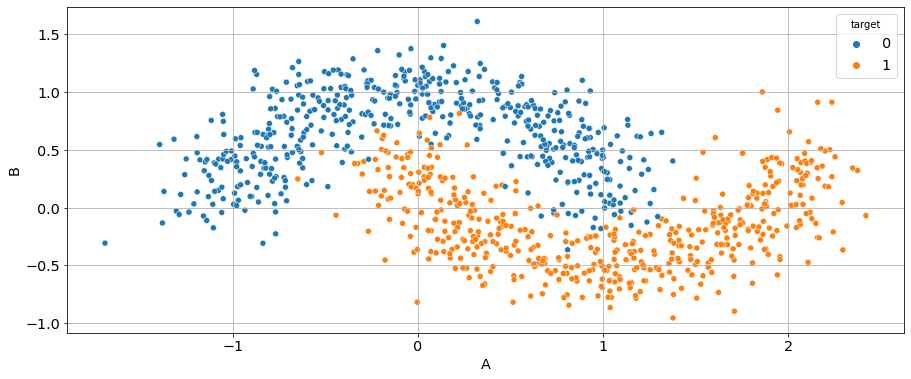

In [11]:
# Using Seaborn
ax = sns.scatterplot(x='A', y='B', data=data_df, hue='target')
ax.grid();

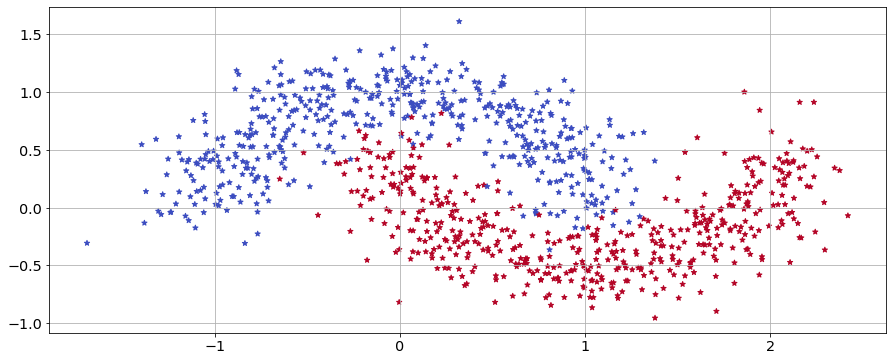

In [12]:
#### In case you want to plot X Array directly
plt.scatter(X[:,0], X[:,1], s=30, c=y, marker = '*', cmap=CMAP)
plt.grid();

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training.
    Note that the data is already random.
</p>

In [13]:
data_train, data_test = data_df.to_numpy()[:900], data_df.to_numpy()[900:]

print (data_train.shape, data_test.shape)

print (type(data_train), type(data_test))

(900, 3) (100, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Over to Perceptron

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in previous lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
\mathrm{or}\\
z & = X . W + b \\
\end{aligned}
$$
<br/>

$$
\begin{equation*}
\hat{y} =  \begin{vmatrix}
1.0 for z>=0  \\
0.0 for z<0\\
\end{vmatrix}
\end{equation*}
$$

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
<p>
As we know that adjustments in the weights are (a-$\hat{y}$). We don't want to adjust by full value. It makes convergence easier if we adjust by a small fraction. </p>
    <p><b>Why?</b> We would know better all through this module. We will circle back to learning_rate after some sessions.
<p>Let's assume that adjusting weights by `$\alpha$ * (a-$\hat{y}$)` makes better sense. </p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant.
</p>
</div>

## Activation Function

In [14]:
# sigmoid function is applied to each Value independently
def fn_sigmoid(z : np.ndarray)-> np.ndarray:
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        sigmoid values of z
    
    '''
    
    return 1 / ( 1 + np.exp ( -z ) )

In [15]:
sm = fn_sigmoid(np.asarray([[-1, 0., 1.], [-np.inf, 0., np.inf]]))
print (sm)

[[0.26894142 0.5        0.73105858]
 [0.         0.5        1.        ]]


## 5. Prediction

In [16]:
# A function to make predictions

def predict(row: np.ndarray, weights : np.ndarray) -> np.float64:
    '''
    Args: 
        row: one data row.
        weights: array with first value as b and then w1 and w2.
    return:
        0 if sum is negative else 1. Simplest form of activation function.
    '''
    
    # building up z = X * W + b
    z = weights[0] # Initialize with b, bias
    
    for i in range(len(row)-1):
        
        z += weights[i + 1] * row[i] # and weights are added here to the values
        a = fn_sigmoid(z)

    return 1 if a >=0.5  else 0 # simplest form of activation function

**Its advisable to test the function**

In [17]:
#Unit test
weights = np.array([0.1, 2.0, 1.0])

display(data_df.loc[0])

predict(data_df.loc[0].values, weights)

A         0.906340
B         0.902676
target    0.000000
Name: 0, dtype: float64

1

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <h3>Back-propagation - Estimate Perceptron weights </h3>
    $
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
      $
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$
    </div>
    
 ## 6. Training

In [18]:
def train_weights(train : np.ndarray, alpha : np.float64, n_epoch: np.int64):
    '''
    Args: 
        train: training dataset
        alpha: learning rate
        n_epoch: number of epoch to train
    return:
        errors: list containing errors
        weights: list of updated weights
    '''
    
    # We will be appending errors in a list
    errors = []
    
    #Initialize Weights. In theory b can be zero. For sake of simplicity, let's initialize b as well.         
    weights = np.random.rand(train.shape[1])
    
    # find m; number of samples
    m = train.shape[0]
    
    for epoch in range(n_epoch): # loop for number of epochs
        
        sum_error = 0.0
        
        ###---------------------------------------------------
        ### Note: we are adjusting weights in each of the row.
        ### It is one of the techniques of optimization
        ### More optimization techniques later
        ###---------------------------------------------------
        for row in train:
            
            prediction = predict(row, weights) # make prediction by row
                
            dz = prediction - row[-1] # dz = (a-y) 
            
            sum_error += (prediction - row[-1])**2 # cumulative error for this epoch
            
            # In batch processing we would have updated once for every batch
            # In stochastic gradient descend we need to devide by m...  TTMM :)
            
            weights[0] = weights[0] - alpha * dz / m  # update b
            
            for i in range(len(row)-1):
                
                weights[i + 1] = weights[i + 1] - alpha * dz * row[i] / m # update rest of the weights
        
        errors.append(sum_error / m) # append average error
        
    return errors, weights

In [19]:
# Lets fix some value for learning rate and number of epochs
alpha = ALPHA
n_epoch = EPOCHS

errors, weights = train_weights(data_train, alpha, n_epoch)

print(weights)

[-9.38077750e-05  2.82801323e-04 -5.24143699e-04]


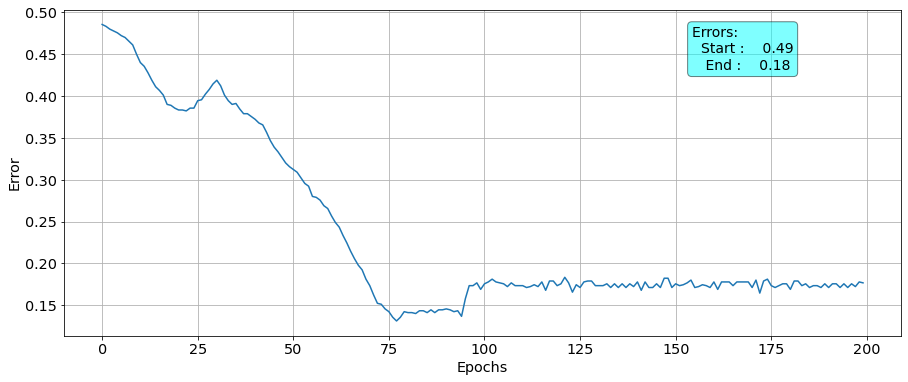

In [20]:
fig, ax = plt.subplots()
ax.plot(errors);

# Little beautification
txtstr = "Errors: \n  Start : {:7.2f}\n   End : {:7.2f}".format(errors[0],errors[-1]) #text to plot

# Properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

# Place a text box in upper left in axes coords

ax.text(0.75, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.grid();

## Question
Why do we keep training and not stop at min training error? Hold on! We would get to that eventually.

## 7. Predictions

### Train Set

In [21]:
predictions = []

for row in data_train:
    
    prediction = predict(row, weights)
    
    predictions.append(prediction)

In [22]:
accuracy_score(data_train[:,-1], predictions)

0.8422222222222222

### Test Set

In [23]:
predictions = []

for row in data_test:
    
    prediction = predict(row, weights)
    
    predictions.append(prediction)

In [24]:
accuracy_score(data_test[:,-1], predictions)

0.89

In [25]:
cm = confusion_matrix(data_test[:,-1], predictions)
cm

array([[54,  4],
       [ 7, 35]], dtype=int64)

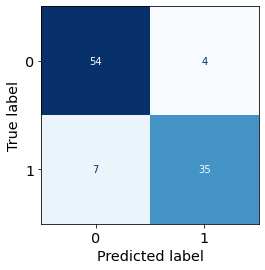

In [26]:
# Create plot object of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

# initialize figure
fig, ax = plt.subplots(figsize = (4,4))

#Plot 
disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();

In [27]:
def fn_plot_decision_boundary(X: np.ndarray):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5));
    
    # Small increment to create object function surface
    dm = 0.05
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()] 

    # add another column filled with 1 to make it work with the predict function
    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
    
    # list to collect predictions
    y_pred = []
    
    # Iterate over rows
    for row in (XX):

        y_p = predict(row, weights)
        y_pred.append(y_p)
        
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2],
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

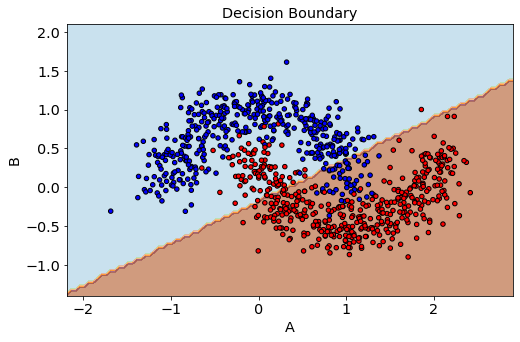

In [28]:
fn_plot_decision_boundary(data_train)